In [1]:
import cv2
import numpy as np
import random
import math
from matplotlib import pyplot as plt


random.seed(42)

# SYSTEM PARAMETERS

You are free to change these but do not add extra variables here. This entire block will be replaced when marking.

You are free modify the parameters but not the variable names.

In [2]:
# DO NOT ADD OTHER VARIABLE HERE

# General settings
seed = 42
image_file = "sample_map.png"

# Task 1 - Occupancy map
unsafe_kernel_size = 7
unsafe_iterations = 3

# Task 3 - BFS
size_of_node_grid = 10
bfs_start_node = 0
bfs_end_node = 99

# Task 4 - PRM and Dijkstra
iterations = 500
k_connections = 3
max_connection_range = 100
start_location = (100,100)
goal_location = (450,450)

# Task 5 - RRT
goal_radius = 20
step = 40

# DO NOT ADD OTHER VARIABLE HERE

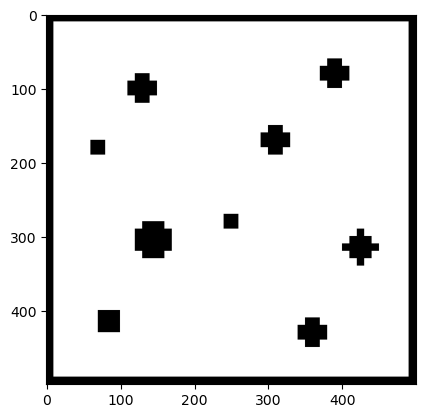

In [3]:
# Task 1.1 (1 mark): Display the occupancy map
image = cv2.imread(image_file) # TODO: Replace with code to load the image

# Display resulting image
plt.imshow(image)
plt.show()


# Task 1 - OCCUPANCY MAP (4 marks total)

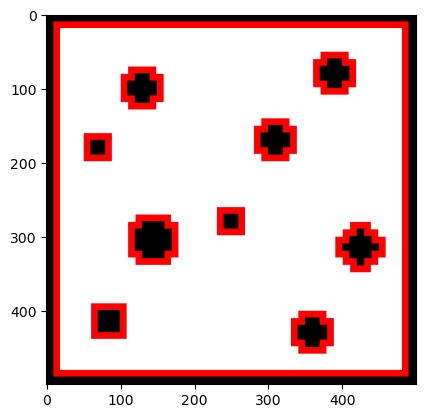

In [4]:
image = cv2.imread(image_file)

kernel = np.ones((unsafe_kernel_size, unsafe_kernel_size), np.uint8) # TODO: Use this kernenl to generate un_safe area
eroded_image = cv2.erode(image, kernel, iterations=unsafe_iterations)
extended_area = cv2.subtract(image, eroded_image)

extended_area_gray = cv2.cvtColor(extended_area, cv2.COLOR_BGR2GRAY)

eroded_image[extended_area_gray > 0] = [255,0,0]

plt.imshow(eroded_image)
plt.show()

# Task 2 - Graph Class (3 marks total)

NOTE: This is slightly different to the graph in lab 07. x,y variables have been added to the node object.

In [5]:
# Task 2.1 (3 marks):  Complete the graph class

class Node:
    
    def __init__(self, node_id, x, y):
        self.id = node_id
        self.x = x
        self.y = y


class Graph:
    
    def __init__(self):
        self.nodes = {}
        self.edges = {}

    def add_node(self, node_id, x, y):
        if node_id not in self.nodes:
            self.nodes[node_id] = Node(node_id, x, y)
            self.edges[node_id] = {}

    def add_edge(self, node_id1, node_id2, weight):
        if node_id1 in self.nodes and node_id2 in self.nodes:
            self.edges[node_id1][node_id2] = weight
            self.edges[node_id2][node_id1] = weight  # Assuming it's an undirected graph

    def get_nodes(self):
        return list(self.nodes.values())


# Task 3 - BFS (8 marks total)

In [6]:
# This is a useful function which you may choose to impliment and use 
# It looks through the image to see if the path is clear between one cooridnate to the next
# Returns True or False 
def path_clear(image, x1, y1, x2, y2):
    
    clear = True
    
    return clear

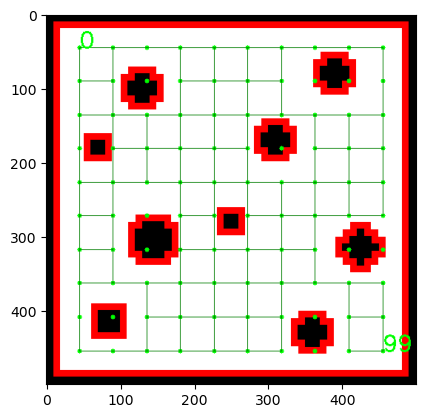

In [7]:
# Task 3.1 (4 marks): Generate a grid of nodes and connect the edges
margin = 45
space = (500-2*margin) / (size_of_node_grid-1)

bfs_image = eroded_image.copy()
bfs_graph = Graph()


# 添加所有结点
for i in range(size_of_node_grid**2):
    row = i // size_of_node_grid
    column = i % size_of_node_grid
    bfs_graph.add_node(i, int(margin+row*space), int(margin+column*space))
    
    
# 添加所有 edge
for i in range(size_of_node_grid**2):
    row = i // size_of_node_grid
    column = i % size_of_node_grid
    X_current = bfs_graph.nodes[i].x
    Y_current = bfs_graph.nodes[i].y
    # 向右添加 edge
    if column < size_of_node_grid-1:
        no_obstacle = 1
        Y_right = bfs_graph.nodes[i+1].y
        # 检查 →线段 内有无障碍物
        for Y in range(Y_current+1, Y_right):
            if not np.array_equal(bfs_image[X_current][Y], [255, 255, 255]):
                no_obstacle = 0
                break  
        if no_obstacle == 1:
            bfs_graph.add_edge(i, i+1, 1)
    # 向下添加 edge
    if row < size_of_node_grid-1:
        no_obstacle = 1
        X_down = bfs_graph.nodes[i+size_of_node_grid].x
        # 检查 ↓线段 内有无障碍物
        for X in range(X_current+1, X_down):
            # print(bfs_image[X_current][Y])
            if not np.array_equal(bfs_image[X][Y_current], [255, 255, 255]):
                no_obstacle = 0
                break
        if no_obstacle == 1:
            bfs_graph.add_edge(i, i+size_of_node_grid, 1)
    

# 绘制所有 node
for Nd in bfs_graph.get_nodes():
    # bfs_image[Nd.x][Nd.y] = [0,255,0]
    cv2.circle(bfs_image, (Nd.x,Nd.y), 3, [0,255,0], -1)
    
    
# 绘制所有 edge
for i in range(size_of_node_grid**2):
    X_current = bfs_graph.nodes[i].x
    Y_current = bfs_graph.nodes[i].y
    # 绘制 → edge
    if i+1 in bfs_graph.edges[i]:
        Y_right = bfs_graph.nodes[i+1].y
        # for Y in range(Y_current+1, Y_right):
        #     bfs_image[X_current,Y] = [0, 125, 0]
        cv2.line(bfs_image, (Y_current, X_current), (Y_right, X_current), (0, 125, 0), 1)
    # 绘制 ↓ edge
    if i+size_of_node_grid in bfs_graph.edges[i]:
        X_down = bfs_graph.nodes[i+size_of_node_grid].x
        # for X in range(X_current+1, X_down):
        #     bfs_image[X,Y_current] = [0, 125, 0]
        cv2.line(bfs_image, (Y_current, X_current), (Y_current, X_down), (0, 125, 0), 1)


# 绘制 起点和终点的数字标签
cv2.putText(bfs_image, '0', (margin,margin), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,255,0], 2)
cv2.putText(bfs_image, str(size_of_node_grid**2-1), (500-margin,500-margin), cv2.FONT_HERSHEY_SIMPLEX, 1, [0,255,0], 2)



plt.imshow(bfs_image)
plt.show()


In [8]:
# Task 3.2 (4 marks): Impliment BFS


def bfs(graph, start_node_id, end_node_id):

    queue = [start_node_id]
    visited = {start_node_id: None}
    
    while queue:
        current = queue.pop(0)
        
        if current == end_node_id:
            break
        
        for neighbor in graph.edges[current]:
            if neighbor not in visited:
                visited[neighbor] = current
                queue.append(neighbor)
    
    path = []
    while current is not None:
        path.append(current)
        current = visited[current]
    
    path.reverse()
    
    return path

Path: [0, 1, 2, 3, 4, 5, 6, 16, 26, 27, 37, 47, 57, 67, 77, 78, 79, 89, 99]


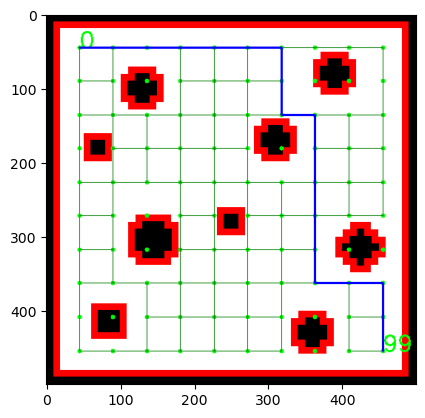

In [9]:
# Task 3.2: Impliment BFS continued


path = bfs(bfs_graph,bfs_start_node,bfs_end_node)


print(f"Path: {path}")


for i in range(len(path) - 1):
    
    node_current = bfs_graph.nodes[path[i]]
    node_next = bfs_graph.nodes[path[i + 1]]
    cv2.line(bfs_image, (node_current.y, node_current.x), (node_next.y, node_next.x), (0, 0, 255), 2)

plt.imshow(bfs_image)
plt.show()

# Task 4 -  PRM and Dijkstra Algorithm (6 marks total)

In [10]:
# This is a useful function which you may choose to impliment and use 
# It finds and returns the n closest nodes which are within the range
def find_closest_nodes(image,graph, target_x, target_y, n,range):

    distances = []

    return distances[:n]


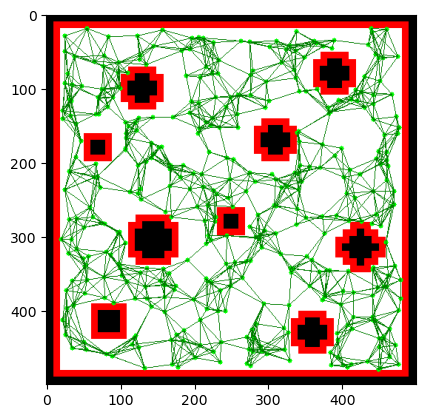

In [11]:
# Task 4.1 (3 marks): PRM
# NOTE: The iteration only increases when a valid node is placed on the map. If the node is invalid, the program should continue without incrementing the iteration count. 

prm_image = eroded_image.copy()
prm_graph = Graph()
random.seed(seed)


# 返回两点之间线段上的所有点
def points_in_line(x1, y1, x2, y2):

    all_points = []
    
    dx = abs(x2 - x1)
    dy = abs(y2 - y1)
    
    err = dx - dy
    
    sx = 1 if x1 < x2 else -1
    sy = 1 if y1 < y2 else -1
    
    while True:
        all_points.append((x1, y1))
        if x1 == x2 and y1 == y2:
            break
        e = err * 2
        if e > -dy:
            err -= dy
            x1 += sx
        if e < dx:
            err += dx
            y1 += sy
            
    return all_points



# 添加所有 node
prm_graph.add_node(-2,goal_location[0],goal_location[1]) # end node
prm_graph.add_node(-1,start_location[0],start_location[1]) # start node


i = 0
while i < iterations:
    x = random.randint(0, prm_image.shape[0]-1)
    y = random.randint(0, prm_image.shape[1]-1)

    if np.array_equal(prm_image[x][y], [255,255,255]):
        prm_graph.add_node(i, x, y)
        
    i += 1


# 添加所有 edge
Nds = prm_graph.get_nodes()
i = 0
while i < len(Nds):
    # 获取 当前的 Node
    Nd_current = Nds[i]
    # 存储所有半径以内的 Node
    All_Nd = {}
    # 遍历其它 Node
    j = 0
    while j < len(Nds):
        # 避免和自己比较
        if j == i:
            j += 1
            continue  
        # 判断距离
        Nd_compared = Nds[j]
        Nds_range = math.sqrt((Nd_current.x-Nd_compared.x)**2+(Nd_current.y-Nd_compared.y)**2)
        if (Nds_range <= max_connection_range):
            # 判断两点之间是否有 obstacle
            line_points = points_in_line(Nd_current.x, Nd_current.y, Nd_compared.x, Nd_compared.y)
            no_obstacle = 1
            for point in line_points:
                if not np.array_equal(prm_image[point[0]][point[1]], [255, 255, 255]):
                    no_obstacle = 0
                    break   
            if no_obstacle == 1: 
                if Nd_compared.id not in prm_graph.edges[Nd_current.id]:
                    All_Nd[Nds_range] = Nd_compared
        j += 1
    # 选出最近的3个Node
    k_connections = 4
    All_Nd = sorted(All_Nd.items())[:k_connections]
    for item in All_Nd:
        prm_graph.add_edge(Nd_current.id, item[1].id, item[0])
        
    i += 1
    


# 绘制所有 node
for Nd in prm_graph.get_nodes():
    cv2.circle(prm_image, (Nd.y,Nd.x), 3, [0,255,0], -1)
    
    
# 绘制所有 edge
for Nd_current in prm_graph.edges:
    # 当前Node的坐标
    X_current = prm_graph.nodes[Nd_current].x
    Y_current = prm_graph.nodes[Nd_current].y
    # 连接 当前Node附近的所有点
    Nds = prm_graph.edges[Nd_current]
    for Nd_connected in Nds:
        X_connected = prm_graph.nodes[Nd_connected].x
        Y_connected = prm_graph.nodes[Nd_connected].y
        cv2.line(prm_image, (Y_current, X_current), (Y_connected, X_connected), (0, 125, 0), 1)



# Display resulting image
plt.imshow(prm_image)
plt.show()

In [12]:
# Task 4.2 (3 marks): Djistraks
# Example output - Path: [-1, 143, 43, 1, 14, 44, 67, 7, 9, 4, 12, 364, -2], Cost: 561.9189671797234
def dijkstra(edges, start_id, end_id):

    # 初始化所有节点的最短距离为无穷大，并设置起点的距离为0
    distances = {node: float(99999) for node in edges}
    distances[start_id] = 0

    # 初始化一个字典来存储每个节点的前驱节点
    previous_nodes = {node: None for node in edges}

    # 使用一个列表来模拟优先队列，起点开始
    nodes_to_visit = list(edges.keys())

    while nodes_to_visit:
        # 找到未访问节点中距离起点最近的节点
        current_node = min(
            nodes_to_visit, key=lambda node: distances[node])

        # 如果最近的节点是目标节点：构建 path，并计算 total_cost
        if current_node == end_id:
            # 构建 path
            path = []
            while previous_nodes[current_node] is not None:
                path.append(current_node)
                current_node = previous_nodes[current_node]
            path.append(start_id)
            path = path[::-1]
            # 计算 total_cost
            total_cost = 0
            for i in range(len(path)):
                if i < len(path)-1:
                    total_cost += edges[path[i]][path[i+1]]

            return (path, total_cost)

        # 从待访问列表中移除当前节点
        nodes_to_visit.remove(current_node)

        # 更新当前节点的邻居节点的距离
        for neighbor, cost in edges[current_node].items():
            alternative_route = distances[current_node] + cost

            # 如果找到更短的路径，则更新邻居节点的最短距离和前驱节点
            if alternative_route < distances[neighbor]:
                distances[neighbor] = alternative_route
                previous_nodes[neighbor] = current_node

    return None




Path: [-1, 421, 385, 127, 471, 335, 463, 174, 481, 94, 430, 167, 398, 177, 412, 362, 445, 126, 467, -2], Cost: 540.5479707641775


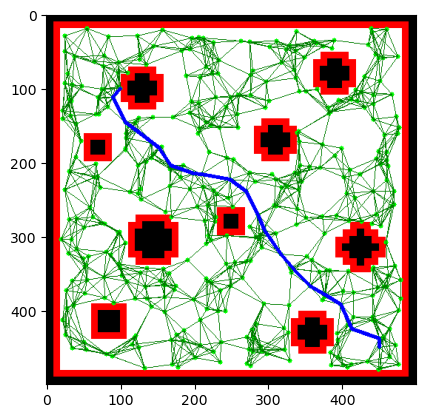

In [13]:
# Task 4.2: Djistraks continued

# Add start (node id = -1) and end (node_id = -2 ) nodes 
# prm_graph.add_node(-1,0,0) # start node
# prm_graph.add_node(-2,0,0) # end node

(path, cost) = dijkstra(prm_graph.edges, -1, -2)
print(f"Path: {path}, Cost: {cost}")


# Display resulting image
# 绘制路线
for i in range(len(path)):
    if i < len(path)-1:
        id_current = path[i]
        id_connected = path[i+1]
        # 当前Node的坐标
        X_current = prm_graph.nodes[id_current].x
        Y_current = prm_graph.nodes[id_current].y
        # 下一个Node的坐标
        X_connected = prm_graph.nodes[id_connected].x
        Y_connected = prm_graph.nodes[id_connected].y
        cv2.line(prm_image, (Y_current, X_current), (Y_connected, X_connected), (0, 0, 255), 3)
        

plt.imshow(prm_image)
plt.show()


# Task 5 - Rapidly-exploring random trees (RRT) (4 marks total)

In [14]:
# This is a useful function which you may choose to impliment and use 
# Given a random point it extends the tree by either the step distance or the cartesian distance
def calculate_new_tree_point( x_closest, y_closest, x, y,step):

    x = 0
    y = 0
    distance = 0
    
    return x, y, distance
    

# This is a useful function which you may choose to impliment and use 
# It finds and returns the closest node to a point on the image
def find_closest_node_rrt(graph, target_x, target_y):

    distances = []

    return distances[0]


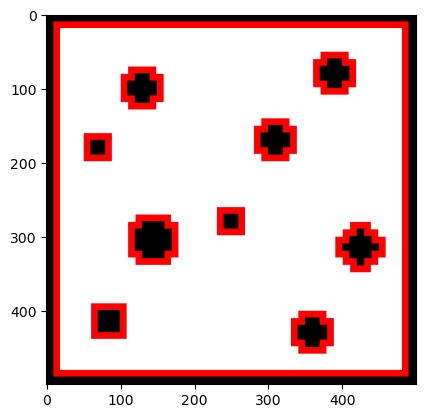

In [15]:
# Task 5.1 (3 marks): RRT/RRT*
# Use the same start and goal locations as PRM 

# NOTE: for this implimentation the next iteration is reach only if a valid node is placed
# If, from the source location there is no valid path to the newly placed node. Then the iteration is repeated and a new random x,y location are selected 

rrt_image = eroded_image.copy()
rrt_graph = Graph()
random.seed(seed)

# Generate the start node with a node_ID of -1

i = 0
while i < iterations:
    
    x = random.randint(0, rrt_image.shape[0]-1)
    y = random.randint(0, rrt_image.shape[1]-1)
    
    i += 1


# Display resulting image
plt.imshow(rrt_image)
plt.show()


#### Task 5.2 (1 mark) - Provide a pharagraph about informed RRT, discuss the advantages proposed in the paper.

Provide your answer in this markdown box:


